## TOTVS CASE STUDY

Instructions:

1. Parse and extract the data.
2. Identify a pattern on any set of fields that can help predict how much a customer will spend.
3. Calculate a sales forecast for the next week.

### Item 1: Parse and extract the data.

The data seems to be in JSON format in a .txt file. <br>
Lets use the *json* library to read it.

In [1]:
import json # json library
from pandas.io.json import json_normalize # json normalization module

import pandas as pd, numpy as np # data processing, linear alg libraries
import matplotlib.pyplot as plt, seaborn as sns # graph libraries

import lightgbm as lgb ## benchmark library for SGD (bit worse than xgboost in results, but about 10 times faster)
from sklearn import * ## pretty much everything related to models.

%matplotlib inline # graphics in noteboook

pd.options.display.max_columns = 99 # setting matrix columns max display value

/home/ubuntu/anaconda2/envs/totvs/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/ubuntu/anaconda2/envs/totvs/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/home/ubuntu/anaconda2/envs/totvs/lib/python2.7/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. Th

In [2]:
with open('sample.txt') as json_data:
    
    data = json.load(json_data)

In [3]:
parsed_json = json_normalize(data)

print (parsed_json.shape)

(1635, 31)


In [4]:
parsed_json.columns

Index([u'complemento.valorTotal', u'dets', u'emit.cnpj',
       u'emit.enderEmit.fone', u'emit.enderEmit.uf', u'emit.enderEmit.xBairro',
       u'emit.enderEmit.xLgr', u'emit.enderEmit.xMun', u'emit.enderEmit.xPais',
       u'emit.xFant', u'ide.dhEmi.$date', u'ide.natOp', u'infAdic.infCpl',
       u'total.icmsTot.vDesc', u'total.icmsTot.vFrete',
       u'total.icmsTot.vOutro', u'total.icmsTot.vProd', u'total.icmsTot.vSeg',
       u'total.icmsTot.vTotTrib', u'total.icmsTot.vbc', u'total.icmsTot.vbcst',
       u'total.icmsTot.vcofins', u'total.icmsTot.vicms',
       u'total.icmsTot.vicmsDeson', u'total.icmsTot.vii',
       u'total.icmsTot.vipi', u'total.icmsTot.vnf', u'total.icmsTot.vpis',
       u'total.icmsTot.vst', u'versaoDocumento',
       u'versaoDocumento.$numberLong'],
      dtype='object')

In [5]:
parsed_json.head(3)

,complemento.valorTotal,dets,emit.cnpj,emit.enderEmit.fone,emit.enderEmit.uf,emit.enderEmit.xBairro,emit.enderEmit.xLgr,emit.enderEmit.xMun,emit.enderEmit.xPais,emit.xFant,...,total.icmsTot.vcofins,total.icmsTot.vicms,total.icmsTot.vicmsDeson,total.icmsTot.vii,total.icmsTot.vipi,total.icmsTot.vnf,total.icmsTot.vpis,total.icmsTot.vst,versaoDocumento,versaoDocumento.$numberLong
0,24.90,"[{u'prod': {u'xProd': u'AGUA', u'vProd': 3.5, ...",01.234.567/0001-89,1-650-933-4902,CA,,650 Castro St. unit 210,Mountain View,United States,TOTVS Labs,...,0.0,0.0,0.0,0.0,0.0,24.90,0.0,0.0,1.0,NaN
1,92.53,"[{u'prod': {u'xProd': u'BUFFET', u'vProd': 83....",01.234.567/0001-89,1-650-933-4902,CA,,650 Castro St. unit 210,Mountain View,United States,TOTVS Labs,...,0.0,0.0,0.0,0.0,0.0,92.55,0.0,0.0,1.0,NaN
2,57.86,"[{u'prod': {u'xProd': u'SUCO', u'vProd': 4.5, ...",01.234.567/0001-89,1-650-933-4902,CA,,650 Castro St. unit 210,Mountain View,United States,TOTVS Labs,...,0.0,0.0,0.0,0.0,0.0,57.87,0.0,0.0,1.0,NaN


### First thoughts

The JSON file seems to be a merge of different tables from a database. <br>
Each row appears to contain the metadata of a single transaction. <br>
The *dets* column has another JSON, which will be explored further. <br>
Most columns seem to be in the format "entity"."attribute", but some do not follow that structure, while a few elements have a single mention to that entity. <br>
<br>
The dets column will be separated into another dataframe object, we will create an 'order_id' as reference key.

In [6]:
parsed_json['order_id'] = np.arange(len(parsed_json))

dets = parsed_json.pop('dets')

In [7]:
json_normalize(dets[0])

,nItem,prod.indTot,prod.qCom,prod.uCom,prod.vProd,prod.vUnCom,prod.xProd
0,1,1,1.000,UN,3.5,3.5,AGUA
1,2,1,0.312,KG,21.4,68.6,BUFFET


In [8]:
data = []

for n,row in enumerate(dets):
    
    for values in json_normalize(row).values:
    
        data.append(np.concatenate([[n], values]))
    
cols = np.concatenate([['order_id'],json_normalize(row).columns])

data = pd.DataFrame(data, columns=cols)

In [9]:
print (data.shape)

(3547, 8)


In [10]:
data.head()

,order_id,nItem,prod.indTot,prod.qCom,prod.uCom,prod.vProd,prod.vUnCom,prod.xProd
0,0,1,1,1.000,UN,3.50,3.5,AGUA
1,0,2,1,0.312,KG,21.40,68.6,BUFFET
2,1,1,1,1.218,KG,83.55,68.6,BUFFET
3,1,2,1,2.000,UN,9.00,4.5,REFRIGERANTE
4,2,1,1,1.000,UN,4.50,4.5,SUCO


In [11]:
data.tail()

,order_id,nItem,prod.indTot,prod.qCom,prod.uCom,prod.vProd,prod.vUnCom,prod.xProd
3542,1633,2,1,1.000,UN,4.95,4.95,REFRIGERANTE
3543,1633,3,1,1.000,UN,4.95,4.95,REFRIGERANTE
3544,1633,4,1,1.000,UN,4.95,4.95,REFRIGERANTE
3545,1634,1,1,0.406,KG,27.85,68.60,BUFFET
3546,1634,2,1,1.000,UN,4.95,4.95,REFRIGERANTE


### 2. Identify a pattern on any set of fields that can help predict how much a customer will spend.

There's alot of data in the JSON file. <br>
Before we try to identify relevant features, or even make new features, lets discard the features that cannot be used or that dont generate any value to predict spending. <br><br>
Naturally, we cannot use any of the values of the entity "total", as they refer to the spending itself.

In [12]:
relevant_json = parsed_json[[col for col in parsed_json.columns if 'total.' not in col]]
relevant_json.head()

,complemento.valorTotal,emit.cnpj,emit.enderEmit.fone,emit.enderEmit.uf,emit.enderEmit.xBairro,emit.enderEmit.xLgr,emit.enderEmit.xMun,emit.enderEmit.xPais,emit.xFant,ide.dhEmi.$date,ide.natOp,infAdic.infCpl,versaoDocumento,versaoDocumento.$numberLong,order_id
0,24.90,01.234.567/0001-89,1-650-933-4902,CA,,650 Castro St. unit 210,Mountain View,United States,TOTVS Labs,2016-01-05T12:01:54.000Z,VENDA,Mesa 2,1.0,NaN,0
1,92.53,01.234.567/0001-89,1-650-933-4902,CA,,650 Castro St. unit 210,Mountain View,United States,TOTVS Labs,2016-01-05T12:03:52.000Z,VENDA,Mesa 1,1.0,NaN,1
2,57.86,01.234.567/0001-89,1-650-933-4902,CA,,650 Castro St. unit 210,Mountain View,United States,TOTVS Labs,2016-01-05T12:16:40.000Z,VENDA,Mesa 5,1.0,NaN,2
3,34.97,01.234.567/0001-89,1-650-933-4902,CA,,650 Castro St. unit 210,Mountain View,United States,TOTVS Labs,2016-01-05T12:17:50.000Z,VENDA,Mesa 3,1.0,NaN,3
4,46.23,01.234.567/0001-89,1-650-933-4902,CA,,650 Castro St. unit 210,Mountain View,United States,TOTVS Labs,2016-01-05T12:18:35.000Z,VENDA,Mesa 4,1.0,NaN,4


Now, lets spot the features that are redundant.

In [13]:
relevant_json.nunique()

complemento.valorTotal         1288
emit.cnpj                         1
emit.enderEmit.fone               1
emit.enderEmit.uf                 1
emit.enderEmit.xBairro            1
emit.enderEmit.xLgr               1
emit.enderEmit.xMun               1
emit.enderEmit.xPais              1
emit.xFant                        1
ide.dhEmi.$date                1629
ide.natOp                         1
infAdic.infCpl                   83
versaoDocumento                   1
versaoDocumento.$numberLong       1
order_id                       1635
dtype: int64

In [14]:
relevant_json = relevant_json[relevant_json.nunique()[relevant_json.nunique()!=1].index]

relevant_json.drop('order_id',1,inplace=True)

relevant_json.head()

,complemento.valorTotal,ide.dhEmi.$date,infAdic.infCpl
0,24.90,2016-01-05T12:01:54.000Z,Mesa 2
1,92.53,2016-01-05T12:03:52.000Z,Mesa 1
2,57.86,2016-01-05T12:16:40.000Z,Mesa 5
3,34.97,2016-01-05T12:17:50.000Z,Mesa 3
4,46.23,2016-01-05T12:18:35.000Z,Mesa 4


We also drop the *order_id* column, which is only a reference key we made earlier.

Not bad, we went from ~30 cols to just 3 columns, one of which is the target variable itself!

Hence, the only features in this json file that could provide any insight are the table on which the client was served, and the date/time or the order.

#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------# <br>
#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------# <br>


For insights, we may take several different approaches.

Graphical analysis is always useful, not only its an easy and fast way to visualize the data as a whole, but its the easiest way to present information to non-technical stakeholders.

Hence, lets try a few graphs, such as:

* time series visualization.

* few histogram and distributions of spending per cohort

* heatmap out of Pearson Correlation can also be a nice way to present data to stakeholders.

* random forest or SGD's feature importance graph 

In [15]:
relevant_json['ide.dhEmi.$date'] = pd.to_datetime(relevant_json['ide.dhEmi.$date'])

print ('min date:', relevant_json['ide.dhEmi.$date'].min())
print ('max date:', relevant_json['ide.dhEmi.$date'].max())

('min date:', Timestamp('2016-01-05 12:01:54'))
('max date:', Timestamp('2016-01-23 14:56:35'))


#### data pre processing

first, we convert the date column to a datetime object (previously it was a string) <br>
the features we extract out of the datetime are:
    
    * date 
    * day of week (0 to 6, 0 being monday) 
    * day of month 
    * hour_round (17:55 -> 17) 
    * hour_float (17:30 -> 17,5)
    
Since the data is only from a short time interval (from 5th january to 23th january of 2016) we do not make features out of the year/month <br><br>
Its also worth noticing that most likely the data from the 5th and from the 23th is incomplete, one can infer that from the timestamps of the min/max values

In [16]:
relevant_json['date'] = relevant_json['ide.dhEmi.$date'].map(lambda date: date.date())
relevant_json['day_of_week'] = relevant_json['ide.dhEmi.$date'].map(lambda date: date.weekday())
relevant_json['day_of_month'] = relevant_json['ide.dhEmi.$date'].map(lambda date: date.day)
relevant_json['hour_round'] = relevant_json['ide.dhEmi.$date'].map(lambda date: date.hour)
relevant_json['hour_float'] = relevant_json['ide.dhEmi.$date'].map(lambda date: date.hour + date.minute/60.0)

#### graphical analysis

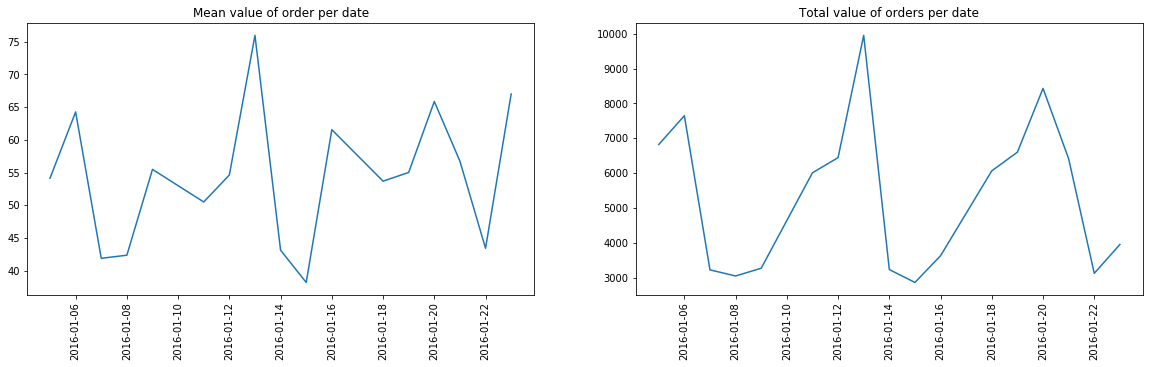

In [17]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)

plt.plot(relevant_json.groupby(['date'])['complemento.valorTotal'].apply(np.mean))
plt.xticks(rotation=90)
plt.title('Mean value of order per date')

plt.subplot(1,2,2)

plt.plot(relevant_json.groupby(['date'])['complemento.valorTotal'].apply(np.sum))
plt.xticks(rotation=90)
plt.title('Total value of orders per date')

plt.show()

In [18]:
relevant_json['table_number'] = relevant_json['infAdic.infCpl'].map(lambda string: int(string.replace('Mesa','')))

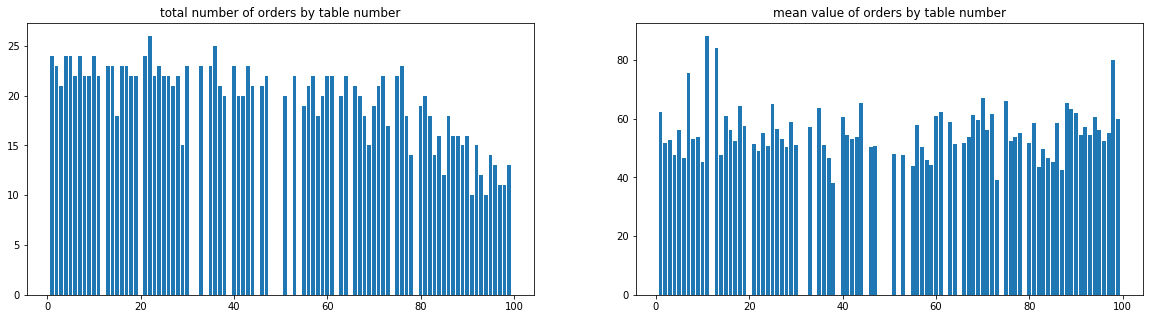

In [19]:
plt.figure(figsize=(20,5))

temp = relevant_json.groupby(['table_number'])['complemento.valorTotal'].apply(len)
X = temp.index
y = temp.values

plt.subplot(1,2,1)
plt.bar(X,y)
plt.title('total number of orders by table number')

temp = relevant_json.groupby(['table_number'])['complemento.valorTotal'].apply(np.mean)
X = temp.index
y = temp.values

plt.subplot(1,2,2)
plt.bar(X,y)
plt.title('mean value of orders by table number')

plt.show()

In [20]:
heatmap_df_tables = relevant_json[['table_number','complemento.valorTotal']]
heatmap_df_tables = pd.concat([heatmap_df_tables.drop('table_number',1), pd.get_dummies(heatmap_df_tables['table_number'],prefix='table_number')],1)

heatmap_df_dates = relevant_json[['complemento.valorTotal','day_of_week','day_of_month','hour_float','hour_round']]
heatmap_df_dates = pd.concat([heatmap_df_dates.drop('day_of_week',1), pd.get_dummies(heatmap_df_dates['day_of_week'],prefix='day_of_week')],1)
heatmap_df_dates = pd.concat([heatmap_df_dates.drop('hour_round',1), pd.get_dummies(heatmap_df_dates['hour_round'],prefix='hour_round')],1)

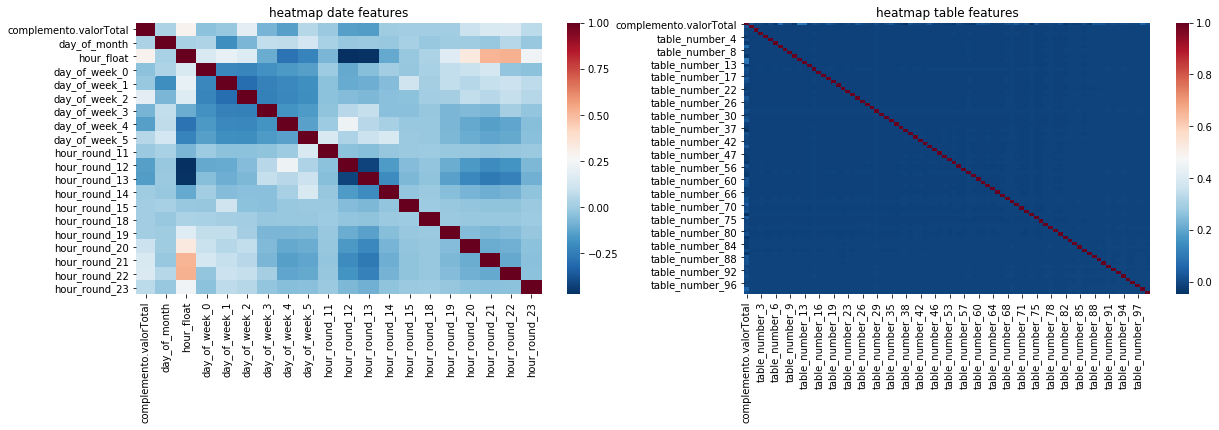

In [21]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)

sns.heatmap(heatmap_df_dates.corr(), cmap='RdBu_r')
plt.title('heatmap date features')

plt.subplot(1,2,2)

sns.heatmap(heatmap_df_tables.corr(), cmap='RdBu_r')
plt.title('heatmap table features')

plt.show()

In [22]:
heatmap_df_tables.corr()['complemento.valorTotal'].sort_values(ascending=False)[:5]

complemento.valorTotal    1.000000
table_number_11           0.097486
table_number_13           0.086867
table_number_7            0.062472
table_number_98           0.051189
Name: complemento.valorTotal, dtype: float64

In [23]:
heatmap_df_tables.corr()['complemento.valorTotal'].sort_values(ascending=True)[:5]

table_number_38   -0.049412
table_number_73   -0.042669
table_number_87   -0.032838
table_number_82   -0.032444
table_number_55   -0.032323
Name: complemento.valorTotal, dtype: float64

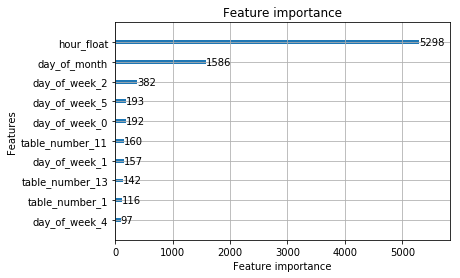

In [24]:
X = pd.concat([heatmap_df_dates.drop('complemento.valorTotal',1),heatmap_df_tables.drop('complemento.valorTotal',1)],1)
y = heatmap_df_dates['complemento.valorTotal']

simple_model = lgb.LGBMRegressor(learning_rate=0.01, n_estimators=300)
simple_model.fit(X,y)

ax = lgb.plot_importance(simple_model, max_num_features=10)
plt.show()

### Insights and conclusions from part 2

* sales behavior (amount and total value) seem to be periodic. A longer period, or to cohort by weekdays, might bring more insights.
* some tables seem to be more or less popular than avg (amount of orders from table), while some tables seem to be more "efficient" (avg value of order) - however, we lack information, its possible that some of those tables were made available, or shut down, during the data collection period. Other features (not provided) could help explain those behaviors, such as table size, or table location.
* evening (21:00-23:00) orders seem to be much more profitable (avg value per order), maybe the establishment should try to promote events during those times (happy hours, game nights, etc) 
* feature importance identifies hour of service as the most important feature for the prediction of the order value.

### 3. Calculate a sales forecast for the next week.

There are many different approaches to calculate a time series prediction. <br>

Most common methods are statistical & numerical approaches. <br>

A simple example of a simple statistical approach would be an avg of the last X days. <br>
A simple example of a numerical approach wld be fitting a model, such as the one did above.

A more in depth solution would be to try a set of different methods, such as those documented in the m4 competition (a famous time series prediction competition, which usually debuts new methods) and to use that which performs the best in a temporal cross validation. Usually, an enseemble of different methods is the best option.<br>

Alternatively, fbook has provided an open source library that they use for time series prediction, *fbprophet*, from its github the description is:<br> "*Prophet is a procedure for forecasting time series data. It is based on an additive model where non-linear trends are fit with yearly and weekly seasonality, plus holidays. It works best with daily periodicity data with at least one year of historical data. Prophet is robust to missing data, shifts in the trend, and large outliers.*"

For this case study, we will make a simple model, and compare how it performs to a simple avg prediction, however, its worth noticing, that the *extremely* short time interval we have to work with (about 2.5 weeks) stops us from doing an in depth approach.

In [25]:
forecast_df = relevant_json[['complemento.valorTotal','date']].groupby('date').apply(sum).reset_index()

forecast_df['dow'] = forecast_df['date'].map(lambda date: date.weekday())
forecast_df['dom'] = forecast_df['date'].map(lambda date: date.day)

In [26]:
## since we are doing a forecast for next week, for our validation, 
## lets use one week, which leaves us with about 10 days worth of trainning date

train = forecast_df[:-7] 
validation = forecast_df[-7:]

In [27]:
train_X = train.drop(['complemento.valorTotal','date'],1)
train_y = train['complemento.valorTotal']

valid_X = validation.drop(['complemento.valorTotal','date'],1)
valid_y = validation['complemento.valorTotal']

In [28]:
clf = lgb.LGBMRegressor(learning_rate=0.01, min_data=1, min_data_in_bin=1)
clf.fit(train_X,train_y)

preds = clf.predict(valid_X)

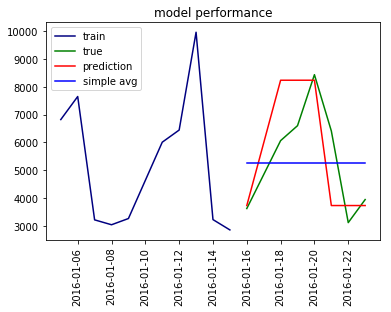

In [29]:
X1 = forecast_df['date'][:-7]
y1 = train_y

X2 = forecast_df['date'][-7:]
y2 = valid_y
y3 = preds
y4 = np.ones(7)*np.mean(train_y)

plt.plot(X1, y1, color='navy')
plt.plot(X2, y2, color='green')
plt.plot(X2, y3, color='red')
plt.plot(X2, y4, color='blue')

plt.title('model performance')
plt.legend(['train','true','prediction','simple avg'])
plt.xticks(rotation=90)

plt.show()

In [30]:
print ('model r2: {}'.format(np.round(metrics.r2_score(valid_y, preds),3)))
print ('simple avg r2: {}'.format(np.round(metrics.r2_score(valid_y, np.ones(7)*np.mean(train_y)),3)))

model r2: 0.334
simple avg r2: -0.013


#### sales forecast

Now that we have shown that even with little data a simple SGD model can give a decent result, <br>
Lets predict the sales forecast for the next week

In [31]:
## make dataframe for next week, noticing we should leave sunday out, as the establishment doesnt open on sundays

next_week = pd.DataFrame([], columns=forecast_df.columns)

dates = np.arange(pd.to_datetime('2016-01-25').date(),pd.to_datetime('2016-01-31').date())

for date in dates:
    
    next_week.loc[len(next_week)] = [pd.to_datetime(date).date(), np.nan, pd.to_datetime(date).date().weekday(), pd.to_datetime(date).date().day]
    
next_week['dow'] = next_week['dow'].map(int)
next_week['dom'] = next_week['dom'].map(int)

next_week

,date,complemento.valorTotal,dow,dom
0,2016-01-25,NaN,0,25
1,2016-01-26,NaN,1,26
2,2016-01-27,NaN,2,27
3,2016-01-28,NaN,3,28
4,2016-01-29,NaN,4,29
5,2016-01-30,NaN,5,30


In [32]:
train_X = forecast_df.drop(['complemento.valorTotal','date'],1)
train_y = forecast_df['complemento.valorTotal']

test_X = next_week.drop(['complemento.valorTotal','date'],1)

In [33]:
clf = lgb.LGBMRegressor(learning_rate=0.01, min_data=1, min_data_in_bin=1)
clf.fit(train_X,train_y)

preds = np.round(clf.predict(test_X),2)
print ('predictions:', preds)

next_week['complemento.valorTotal'] = preds

next_week[['date','complemento.valorTotal']]

('predictions:', array([ 5799.69,  6139.48,  7298.64,  6018.72,  3936.19,  4460.35]))


,date,complemento.valorTotal
0,2016-01-25,5799.69
1,2016-01-26,6139.48
2,2016-01-27,7298.64
3,2016-01-28,6018.72
4,2016-01-29,3936.19
5,2016-01-30,4460.35


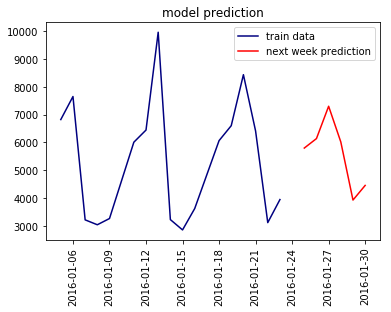

In [34]:
X1 = forecast_df['date']
y1 = forecast_df['complemento.valorTotal']

X2 = dates
y2 = preds

plt.plot(X1, y1, color='navy')
plt.plot(X2, y2, color='red')

plt.title('model prediction')
plt.legend(['train data','next week prediction'])
plt.xticks(rotation=90)

plt.show()